In [1]:
%run ../template.ipynb

In [2]:
exp_id = "050318"
series_names = ["greedy", "stems_cpp", "exhaustive"]
num_apps_range = range(2, 8+1)

In [3]:
setups = {}
for num_apps in num_apps_range:
    setups.update(dataloaders.load_setups(exp_id,
                                          setup_file_str="/setups.{exp_id}-" + str(num_apps) + "{version}.pickle",
                                          legacy='InconsistentIds'))
                                          

Loading setups... Using InconsistentIds... Done
Loading setups... Using InconsistentIds... Done
Loading setups... Using InconsistentIds... Done
Loading setups... Using InconsistentIds... Done
Loading setups... Using InconsistentIds... Done
Loading setups... Using InconsistentIds... Done
Loading setups... Using InconsistentIds... Done


In [4]:
rows = []
# HACK
variants = {
    'greedy': 'v1+metrics',
    'exhaustive': 'v1+cost',
    'stems_cpp': None,
}
for series_name in series_names:
    if series_name == 'exhaustive':
        scheduleloader_kwargs = dict(apps_order='configurations')
    else:
        scheduleloader_kwargs = {}
    schedules = []
    for num_apps in num_apps_range:
        schedules += dataloaders.load_schedules("050318", series_name + ".mainstream.sim.*-" + str(num_apps) + ".v1", variant=variants[series_name], setups=setups, **scheduleloader_kwargs)
    rows += ex(schedules,
#                each=lambda s: {'f1': 1. - s.extra('metric'), 'fps': mean(s.fpses), 'num_apps': s.num_apps, 'budget': s.budget},
               each=lambda s: s.to_map(),
               constant={'scheduler': series_name, 'sharing': 'mainstream'})
df = comb(rows)

In [5]:
def desc(self, verbose=2):
    if verbose == 0:
        return 'Schedule(f1={:g}, fpses={}, frozens={})'.format(self.mean_f1(), self.fpses, self.frozens)
    elif verbose == 2:
        return 'Schedule(f1={:g}, fpses={}, frozens={}, obj={})'.format(self.mean_f1(), self.fpses, self.frozens, self.objectives)

In [6]:
series_name = "exhaustive"
num_apps = 3
schedules = dataloaders.load_schedules("050318", series_name + ".mainstream.sim.150.*" + str(num_apps) + ".v1", variant=variants[series_name], setups=setups, apps_order='configurations')
print desc(schedules[0])

Schedule(f1=0.915013, fpses=[6, 4, 6], frozens=[33, 33, 33], obj=[0.0549195736761, 0.0314129414174, 0.168627364063])


In [7]:
series_name = "stems_cpp"
num_apps = 3
schedules2 = dataloaders.load_schedules("050318", series_name + ".mainstream.sim.150.*" + str(num_apps) + ".v1", variant=variants[series_name], setups=setups)
print desc(schedules2[0])

Schedule(f1=0.915013, fpses=[6, 6, 4], frozens=[33, 33, 33], obj=[0.0549195736761, 0.168627364063, 0.0314129414174])


In [8]:
df_view = df[df['budget'] == 100]
grouped = df_view.groupby(['scheduler', 'num_apps'])

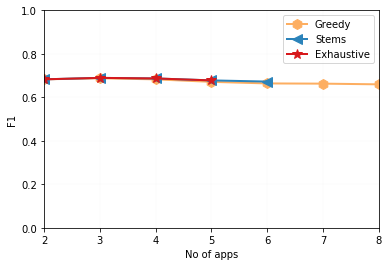

In [9]:
series = agg2series(grouped['f1'].mean(),
                    names=series_names,
                    plotparams=dict(lw=2, markersize=10, linestyle='-', marker='.'))
ax = plot.variants(series, xgrid=grids.x.num_apps, ygrid=grids.y.f1)

/usr/local/lib/python2.7/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


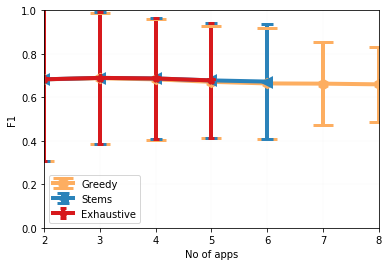

In [10]:
bars = [grouped['f1'].min(), grouped['f1'].max()]
series = agg2series(grouped['f1'].mean(),
                    names=series_names,
                    errs=dict(e_abs=bars),
                    plotparams='fg-e')
ax = plot.variants(series, xgrid=grids.x.num_apps, ygrid=grids.y.f1)

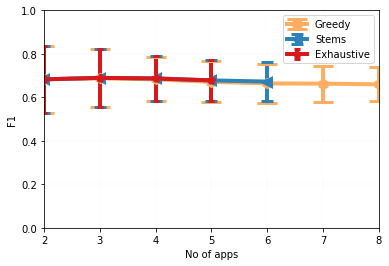

In [11]:
bars = grouped['f1'].std()
series = agg2series(grouped['f1'].mean(),
                    names=series_names,
                    errs=dict(e_delta=bars),
                    plotparams='fg-e')
ax = plot.variants(series, xgrid=grids.x.num_apps, ygrid=grids.y.f1)